# Исследование поведения пользователей разных тарифов сотового оператора

### Подготовка данных

Загрузим нужные библиотеки и посмотрим на данные. Сразу снизу запишу на какие вопросы предстоит ответить заказчику на первом этапе.

    * количество сделанных звонков и израсходованных минут разговора по месяцам;
    * количество отправленных сообщений по месяцам;
    * объем израсходованного интернет-трафика по месяцам;
    * помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и    интернет-трафика; остаток умножьте на значение из тарифного плана).
    * Найдите и удалите выбросы. Поясните, по какому принципу вы их искали.

In [10]:
import ast
import math
import warnings
import sys
import datetime


import pandas as pd
import numpy as np



    
# импортируем графические модули
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick

from matplotlib.dates import (YEARLY, DateFormatter,
                              rrulewrapper, RRuleLocator, drange)

from datetime import datetime
from scipy import stats as st

In [11]:
df_calls = pd.read_csv('/datasets/calls.csv')
df_int = pd.read_csv('/datasets/internet.csv')
df_mess = pd.read_csv('/datasets/messages.csv')
df_tar = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')

Посмотрим, что внутри данных
    * как выглядят
    * есть ли nan
    * какие типы

In [12]:
print(df_calls.head())
print(df_calls.info())
print(df_calls.isnull().sum())
print(df_calls['duration'].describe())

       id   call_date  duration  user_id
0  1000_0  2018-07-25      0.00     1000
1  1000_1  2018-08-17      0.00     1000
2  1000_2  2018-06-11      2.85     1000
3  1000_3  2018-09-21     13.80     1000
4  1000_4  2018-12-15      5.18     1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB
None
id           0
call_date    0
duration     0
user_id      0
dtype: int64
count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64


nan нет! Проверим на выбросы.

count    202607.000000
mean          6.755887
std           5.843365
min           0.000000
25%           1.300000
50%           6.000000
75%          10.700000
max          38.000000
Name: duration, dtype: float64


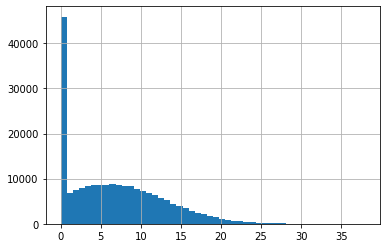

In [13]:
df_calls['duration'].hist(bins = 50)
print(df_calls['duration'].describe())

Есть выброс. природа пока не ясна. Просто возьмем на заметку.

#### Таблица траффика

In [14]:
print(df_int.head())
print(df_int.info())
print(df_int.isnull().sum())

       id  mb_used session_date  user_id
0  1000_0   112.95   2018-11-25     1000
1  1000_1  1052.81   2018-09-07     1000
2  1000_2  1197.26   2018-06-25     1000
3  1000_3   550.27   2018-08-22     1000
4  1000_4   302.56   2018-09-24     1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB
None
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64


count    149396.000000
mean        370.192426
std         278.300951
min           0.000000
25%         138.187500
50%         348.015000
75%         559.552500
max        1724.830000
Name: mb_used, dtype: float64


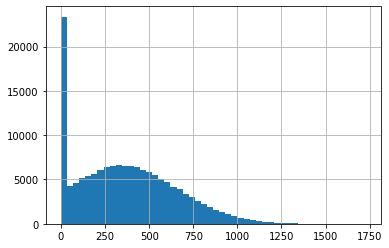

In [15]:
df_int['mb_used'].hist(bins = 50)
print(df_int['mb_used'].describe())

#### Таблица сообщений отправленных пользователемя

In [16]:
print(df_mess.head())
print(df_mess.info())
print(df_mess.isnull().sum())

       id message_date  user_id
0  1000_0   2018-06-27     1000
1  1000_1   2018-10-08     1000
2  1000_2   2018-08-04     1000
3  1000_3   2018-06-16     1000
4  1000_4   2018-12-05     1000
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB
None
id              0
message_date    0
user_id         0
dtype: int64


Таблица и таблица пока ничего конкретного сказать нельзя. Будем смотреть дальше.

#### Таблица пользователей тарифов

In [17]:
print(df_users.head())
print(df_users.info())
print(df_users.isnull().sum())

   user_id  age churn_date         city first_name  last_name    reg_date  \
0     1000   52        NaN    Краснодар     Рафаил  Верещагин  2018-05-25   
1     1001   41        NaN       Москва       Иван       Ежов  2018-11-01   
2     1002   59        NaN  Стерлитамак    Евгений  Абрамович  2018-06-17   
3     1003   23        NaN       Москва      Белла   Белякова  2018-08-17   
4     1004   68        NaN  Новокузнецк    Татьяна   Авдеенко  2018-05-14   

  tariff  
0  ultra  
1  smart  
2  smart  
3  ultra  
4  ultra  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.3+ KB
None
user_id         0
age             0
churn_

In [18]:
print(df_users['age'].describe())

count    500.00000
mean      46.58800
std       16.66763
min       18.00000
25%       32.00000
50%       46.00000
75%       62.00000
max       75.00000
Name: age, dtype: float64


In [19]:
df_users['user_id'].value_counts().head()

1023    1
1194    1
1181    1
1182    1
1183    1
Name: user_id, dtype: int64

Посмотрел вылеты на возможных столбика. Возраст - всё вполне прилично. 

    * Для идентификатора пользвателя посмотрел неповторяелся ли он два раза. Для того чтобы понять для себя, о чем вообще говорит нам эта таблица может быть было несколько переходов в месяц по тарифам для пользователя. Но нет в этот раз не стали делать нам больно) 
    * Еще. Так как нам не сказали влияет ли с какой даты пользователь переходил на тариф или пакетный траффик начисляется с начала месяца - таких данных нет. Так что буду считать по более благоприятнаму для себя сценарию. Тарификация с начала месяца. 
    *  Есть nan и это совсем не ошибка так что подумаем позже как их заполнить.

#### Таблица описания тарифов

In [20]:
print(df_tar.head())
print(df_tar.info())
print(df_tar.isnull().sum())

   messages_included  mg_per_month_included  minutes_included  \
0                 50                  15360               500   
1               1000                  30720              3000   

   rub_monthly_fee  rub_per_gb  rub_per_message  rub_per_minute tariff_name  
0              550         200                3               3       smart  
1             1950         150                1               1       ultra  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mg_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 208.0+ bytes
None
messages_included        0
mg_per_month_included    0
minutes_included   

Тарифы и тарифы, всё что надо есть.

## План обработки данных

В общем при обарботки данных придумал как подготовить эти наборы. 
    У нас есть персонализированная таблица с указанием перехода человека на тариф и даты перехода на тариф. Соответсвенно всё, что не в этих числах рассматриваться не может, и для нужного нам итогового набора данных предлагаю сделать следующее. 
    
            * Предобработать данные таблиц.
            
                - Убрать безъимянный столбец в всех табилицах "Unnamed: 0" - удалить.(совершенно не описан и не знаю зачем он нам нужен он коррелируется только с нумерацией записи в датафрейме, но нам она не нужна нужна дата)
                - Все что касается звонков надо округлить до целого в большую сторону и подставить тип int - этот вывод выходит из описания тарифа
                - мегабайты тоже следует округлить вверх до целого числа и присвоить тип int для столбика.
                - Заполнить таблицу с персонализированными данными. Значение даты перехода с тарифа на другой для тоех у кого nan нужно заполнить датой 2019-01-01. Мы изучаем все поведение пользователей за 2018 год так что эта дата будет вполне кстати. 
                - Переименуем столбец дата события в одно и тоже в имя в всех датафреймах чтобы было проще обрабатывать в функции
                - Предобратаем столбец дата и приведем его к значению год-месяц
                - Таблицам "звонки" "интернет трафик" "сообщения" добвить столбик "deleted" по нему я потом избавлюсь от строк с другим тарифом
                - В таблицу "сообщения" добавить столбик с численностью для работы с количеством сообщений в месяц
               
             * Далее если все датафреймы обрабатываются очень похоже пишим функцию которая будет в цикле групировать пользователей и пробегаться циклом по строкам отдавать строку в другую функцию где будет проверяться - этот звонок, сообщение или трафик был сделан в рамках исследуемого тарифа или нет и взводится тип булево по которому потом будет производится удаления из датафрейма. Затем посмотрим на выбросы в этих таблицах останутся они вообще или нет. приведем их скорее к средней. 
             * Сгруппируем таблицы в рамках одного месяца, чтобы их потом можно было просто сооединить
             * Вычислим все нужные столбики: сколько человек потратил за месяца какой перерасход и т.д.

#### Напишим функцию которая удаляет столбик "Unnamed: 0"

In [21]:
def delete_unnamed(df):
    df.drop('Unnamed: 0', axis=1, inplace=True)
    return df

In [22]:
# Оказалось этот столбик появлялся только в моем локальном jupyter notebook

#df_calls = delete_unnamed(df_calls)
#df_int = delete_unnamed(df_int)
#df_mess = delete_unnamed(df_mess)
#df_users = delete_unnamed(df_users)
#df_tar = delete_unnamed(df_tar)

### Предобработаем по очереди все дэйтафреймы в соответсвие с планом

#### Таблица звонков

In [23]:
df_calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [24]:
# Удаляем звонки с продолжительностью в 0.00 это может звонок не принятый абонентом. они нам совсем не интересны.
df_calls = df_calls.drop(np.where(df_calls['duration'] == 0.00)[0])

# Округляем значения продолжительности звонка до целого числа и присваиваем тип int
df_calls['duration'] = np.ceil(df_calls['duration'])
df_calls['duration'] = df_calls['duration'].astype('int')

# Добавляем столбец для признака удаления если строка нам не потребуестся
df_calls['delete'] = False

# Добавим столбик год-месяц ведь нам придется группировать данные для склейки
df_calls['year_month']=df_calls['call_date'].apply(lambda x: str(x)[:7])

# Переименуем столбик с датай события чтобы было проще обрабатывать в функции
df_calls.rename(columns={'call_date':'trf_date'}, inplace=True)

In [25]:
df_calls.info()
df_calls.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 2 to 202606
Data columns (total 6 columns):
id            162994 non-null object
trf_date      162994 non-null object
duration      162994 non-null int64
user_id       162994 non-null int64
delete        162994 non-null bool
year_month    162994 non-null object
dtypes: bool(1), int64(2), object(3)
memory usage: 7.6+ MB


,id,trf_date,duration,user_id,delete,year_month
2,1000_2,2018-06-11,3,1000,False,2018-06
3,1000_3,2018-09-21,14,1000,False,2018-09
4,1000_4,2018-12-15,6,1000,False,2018-12
7,1000_7,2018-08-22,19,1000,False,2018-08
8,1000_8,2018-09-15,19,1000,False,2018-09


#### Таблица интернет трафика

In [26]:
df_int.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [27]:
print(df_int['mb_used'].sort_values(ascending=True).head(1))

116616    0.0
Name: mb_used, dtype: float64


In [28]:
df_int.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 4 columns):
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 4.6+ MB


In [29]:
# Удаляем трафик с расходом в 0.0 Mb
df_int = df_int.drop(np.where(df_int['mb_used'] == 0.0)[0])

# Округляем значения продолжительности звонка до целого числа и присваиваем тип int
df_int['mb_used'] = np.ceil(df_int['mb_used'])
df_int['mb_used'] = df_int['mb_used'].astype('int')

# Добавляем столбец для признака удаления если строка нам не потребуестся
df_int['delete'] = False

# Добавим столбик год-месяц ведь нам придется группировать данные для склейки
df_int['year_month']= df_int['session_date'].apply(lambda x: str(x)[:7])

# Переименуем столбик с датай события чтобы было проще обрабатывать в функции
df_int.rename(columns={'session_date':'trf_date'}, inplace=True)

In [30]:
df_int.info()
df_int.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 129798 entries, 0 to 149395
Data columns (total 6 columns):
id            129798 non-null object
mb_used       129798 non-null int64
trf_date      129798 non-null object
user_id       129798 non-null int64
delete        129798 non-null bool
year_month    129798 non-null object
dtypes: bool(1), int64(2), object(3)
memory usage: 6.1+ MB


,id,mb_used,trf_date,user_id,delete,year_month
0,1000_0,113,2018-11-25,1000,False,2018-11
1,1000_1,1053,2018-09-07,1000,False,2018-09
2,1000_2,1198,2018-06-25,1000,False,2018-06
3,1000_3,551,2018-08-22,1000,False,2018-08
4,1000_4,303,2018-09-24,1000,False,2018-09


#### Таблица сообщений

In [31]:
df_mess.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [32]:
# добавим сечетчик сообщений в день
df_mess['count_mesg'] = int(1)

# Добавляем столбец для признака удаления если строка нам не потребуестся
df_mess['delete'] = False

# Добавим столбик год-месяц ведь нам придется группировать данные для склейки
df_mess['year_month'] = df_mess['message_date'].apply(lambda x: str(x)[:7])

# Переименуем столбик с датай события чтобы было проще обрабатывать в функции
df_mess.rename(columns={'message_date':'trf_date'}, inplace=True)

In [33]:
df_mess.info()
df_mess.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 6 columns):
id            123036 non-null object
trf_date      123036 non-null object
user_id       123036 non-null int64
count_mesg    123036 non-null int64
delete        123036 non-null bool
year_month    123036 non-null object
dtypes: bool(1), int64(2), object(3)
memory usage: 4.8+ MB


,id,trf_date,user_id,count_mesg,delete,year_month
0,1000_0,2018-06-27,1000,1,False,2018-06
1,1000_1,2018-10-08,1000,1,False,2018-10
2,1000_2,2018-08-04,1000,1,False,2018-08
3,1000_3,2018-06-16,1000,1,False,2018-06
4,1000_4,2018-12-05,1000,1,False,2018-12


#### Таблица клиентов

In [34]:
df_users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.3+ KB


In [35]:
# Заполним nan датой 2019-01-01 так как это первая дата которая выходит за пределы дат исследования
df_users['churn_date'] = df_users['churn_date'].fillna('2019-01-01')

In [36]:
df_users.info()
df_users.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    500 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.3+ KB


,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,2019-01-01,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,2019-01-01,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,2019-01-01,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,2019-01-01,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


#### Таблица тарифов

In [37]:
df_tar.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mg_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 208.0+ bytes


In [38]:
# Талблице тарифов просто переименуем столбик чтобы было проще соединить с основной таблицей в будущем
df_tar.rename(columns={'tariff_name':'tariff'}, inplace=True)

#### Напишим функцию которая будет причесывать наши таблицы

Есть опасения, что когда мы соединим в таблицы с пользователями левым соединением может получиться так что какой то из них совсем не пользовался какими то услугами будь то трафик, звонки или сообщения. В этом случае нам придется удалить такие строкии будем их искать по трафику - он же для нас важен

In [39]:
df_total = df_calls.merge(df_users, on='user_id', how='left')
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 162994 entries, 0 to 162993
Data columns (total 13 columns):
id            162994 non-null object
trf_date      162994 non-null object
duration      162994 non-null int64
user_id       162994 non-null int64
delete        162994 non-null bool
year_month    162994 non-null object
age           162994 non-null int64
churn_date    162994 non-null object
city          162994 non-null object
first_name    162994 non-null object
last_name     162994 non-null object
reg_date      162994 non-null object
tariff        162994 non-null object
dtypes: bool(1), int64(3), object(9)
memory usage: 16.3+ MB


In [40]:
# в этой функции будем ставить признак нужно ли удалять эту строку или нет
def set_delete_for_row(x):
   
    # Посмотрим чтобы какая та деятельность входила в дни тарифа
    
    date_churn = datetime.strptime(x['churn_date'], "%Y-%m-%d")
    date_reg = datetime.strptime(x['reg_date'], "%Y-%m-%d")
    date_trf = datetime.strptime(x['trf_date'], "%Y-%m-%d")
    
    if date_trf < date_churn and date_trf >= date_reg:
        return False
    else: 
        return True

# Удаляет не нужные колонки
def delete_column(df):
    delete_column = ['delete','age','city','churn_date','first_name','last_name','reg_date','tariff']
    df.drop(delete_column, axis=1, inplace=True)
    return df    

# Возвращает датафрейм только с траффиком который входил в даты работы тарифа
def prepared_traffic_table(df_traffic, df_usr):
    
    # Соединим таблицы
    df_total = df_traffic.merge(df_usr, on='user_id', how='left')
    
    # Поймем что тут удалять что не стоит
    #for user_id, group_df in df_total.groupby('user_id'):    
    df_total['delete'] = df_total.apply(set_delete_for_row, axis=1)
        
    # Почистим дата фрейм от ненужных строк и столбцов 
    # upd: как оказалось таких и нет но я рад что предусмотрел
    df_total = df_total.drop(np.where(df_total['delete'] == True)[0])
    
    # Удаляем ненужные колонки
    df_total = delete_column(df_total)
    
    # Вернем датафрейм
    return df_total

In [41]:
df_msg_pr = prepared_traffic_table(df_mess, df_users)

In [42]:
df_calls_pr = prepared_traffic_table(df_calls, df_users)
print(df_calls_pr.head())

       id    trf_date  duration  user_id year_month
0  1000_2  2018-06-11         3     1000    2018-06
1  1000_3  2018-09-21        14     1000    2018-09
2  1000_4  2018-12-15         6     1000    2018-12
3  1000_7  2018-08-22        19     1000    2018-08
4  1000_8  2018-09-15        19     1000    2018-09


count    162994.000000
mean          8.897880
std           5.353761
min           1.000000
25%           5.000000
50%           8.000000
75%          12.000000
max          38.000000
Name: duration, dtype: float64


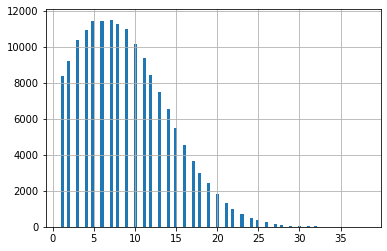

In [43]:
# проверим на выбросы
df_calls_pr['duration'].hist(bins = 100)
print(df_calls_pr['duration'].describe())

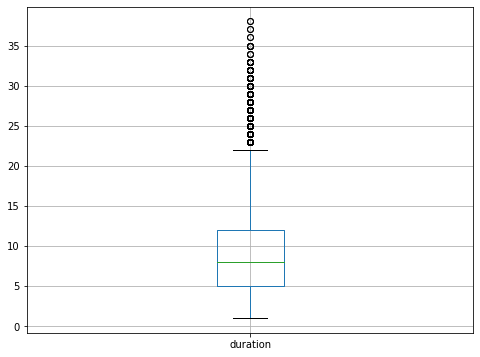

In [44]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
df_calls_pr.boxplot(column='duration', ax=ax)

Для ящика с усами обрежим все выбросы для более точной выборки

In [45]:
df_calls_pr = df_calls_pr.query('duration < 22')

вот теперь нормально!

In [46]:
df_int_pr = prepared_traffic_table(df_int, df_users)
print(df_int_pr.head())

       id  mb_used    trf_date  user_id year_month
0  1000_0      113  2018-11-25     1000    2018-11
1  1000_1     1053  2018-09-07     1000    2018-09
2  1000_2     1198  2018-06-25     1000    2018-06
3  1000_3      551  2018-08-22     1000    2018-08
4  1000_4      303  2018-09-24     1000    2018-09


count    129798.000000
mean        426.581758
std         255.596114
min           1.000000
25%         228.000000
50%         401.000000
75%         593.000000
max        1725.000000
Name: mb_used, dtype: float64


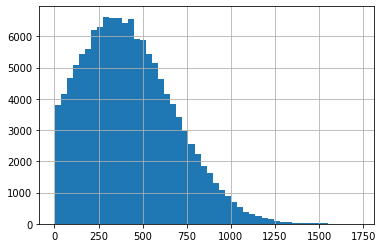

In [47]:
# проверим на выбросы
df_int_pr['mb_used'].hist(bins = 50)
print(df_int_pr['mb_used'].describe())

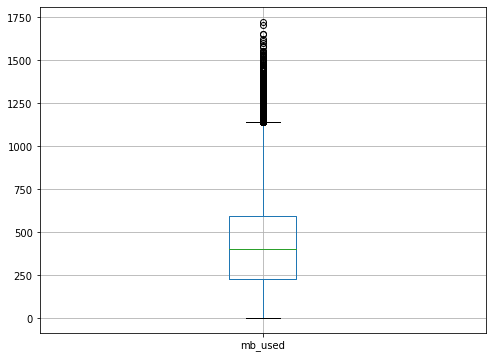

In [48]:
fig = plt.figure(figsize=(8,6))
ax = fig.gca()
df_int_pr.boxplot(column='mb_used', ax=ax)

In [49]:
df_int_pr = df_int_pr.query('mb_used < 1125')

Ящик с усами показал выбросы, что придется обрезать 

#### Создадим функцию которая будет группировать траффик по месяцам

In [50]:
def group_traffic_mounth(df):
    
    # Удалим столбик с датой
    df.drop('trf_date', axis=1, inplace=True)
    
    # Сгруппируем всю деятельность для месяца 
    df = df.groupby(['user_id', "year_month"])
    df = df.agg(sum).reset_index()
    df.index.names = ['id']
    
    return df

In [51]:
df_calls_pr_gr = group_traffic_mounth(df_calls_pr)
df_msg_pr_gr = group_traffic_mounth(df_msg_pr)
df_int_pr_gr = group_traffic_mounth(df_int_pr)

In [52]:
# Соединим таблицы в итоговую
df = df_users.merge(df_calls_pr_gr, on='user_id', how='left')
df = df.merge(df_msg_pr_gr, on=['user_id','year_month'], how='left')
df = df.merge(df_int_pr_gr, on=['user_id','year_month'], how='left')
df = df.merge(df_tar, on='tariff', how='inner')


df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3176 entries, 0 to 3175
Data columns (total 19 columns):
user_id                  3176 non-null int64
age                      3176 non-null int64
churn_date               3176 non-null object
city                     3176 non-null object
first_name               3176 non-null object
last_name                3176 non-null object
reg_date                 3176 non-null object
tariff                   3176 non-null object
year_month               3168 non-null object
duration                 3168 non-null float64
count_mesg               2673 non-null float64
mb_used                  3155 non-null float64
messages_included        3176 non-null int64
mg_per_month_included    3176 non-null int64
minutes_included         3176 non-null int64
rub_monthly_fee          3176 non-null int64
rub_per_gb               3176 non-null int64
rub_per_message          3176 non-null int64
rub_per_minute           3176 non-null int64
dtypes: float64(3), int64

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff,year_month,duration,count_mesg,mb_used,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-05,159.0,22.0,2256.0,1000,30720,3000,1950,150,1,1
1,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-06,172.0,60.0,22059.0,1000,30720,3000,1950,150,1,1
2,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-07,340.0,75.0,14016.0,1000,30720,3000,1950,150,1,1
3,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-08,384.0,81.0,14070.0,1000,30720,3000,1950,150,1,1
4,1000,52,2019-01-01,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,2018-09,466.0,57.0,14581.0,1000,30720,3000,1950,150,1,1


In [53]:
print(df.isnull().sum())

user_id                    0
age                        0
churn_date                 0
city                       0
first_name                 0
last_name                  0
reg_date                   0
tariff                     0
year_month                 8
duration                   8
count_mesg               503
mb_used                   21
messages_included          0
mg_per_month_included      0
minutes_included           0
rub_monthly_fee            0
rub_per_gb                 0
rub_per_message            0
rub_per_minute             0
dtype: int64


In [54]:
filtered_df = df[df['year_month'].isnull()]
print(filtered_df.head(8))

      user_id  age  churn_date              city first_name last_name  \
151      1091   36  2019-01-01  Набережные Челны       Вера   Суслова   
197      1106   67  2019-01-01            Калуга      Исаак    Костин   
228      1128   51  2018-12-23          Волжский     Ксения    Агаева   
380      1231   63  2019-01-01         Чебоксары     Касьян   Авдюков   
550      1328   44  2019-01-01          Мурманск      Рауль  Аркадьев   
925      1473   18  2019-01-01        Красноярск    Николай   Лебедев   
2586     1371   50  2018-12-30              Омск     Ириней  Трофимов   
3131     1489   35  2019-01-01   Санкт-Петербург      Павел  Гончаров   

        reg_date tariff year_month  duration  count_mesg  mb_used  \
151   2018-05-08  ultra        NaN       NaN         NaN      NaN   
197   2018-04-26  ultra        NaN       NaN         NaN      NaN   
228   2018-12-15  ultra        NaN       NaN         NaN      NaN   
380   2018-05-23  ultra        NaN       NaN         NaN      NaN 

In [55]:
df['year_month'] = df['year_month'].fillna(df['reg_date'].apply(lambda x: str(x)[:7]))
df['duration'] = df['duration'].fillna(0)
df['count_mesg'] = df['count_mesg'].fillna(0)
df['mb_used'] = df['mb_used'].fillna(0)

print(df.isnull().sum())

user_id                  0
age                      0
churn_date               0
city                     0
first_name               0
last_name                0
reg_date                 0
tariff                   0
year_month               0
duration                 0
count_mesg               0
mb_used                  0
messages_included        0
mg_per_month_included    0
minutes_included         0
rub_monthly_fee          0
rub_per_gb               0
rub_per_message          0
rub_per_minute           0
dtype: int64


Понятно. Это те кто купил тариф и совсем им не пользовался, может даже забыл симку в телефон вставить их меньше одного процента и их можно смело удалять. Что касается других пропуской то тут все понятно множество людей не пользуется смс особенно в 2018 году ну а пожилие люди могут не пользоваться интернетом хотя это и сложно но и цифра небольшая. Всего 21 месяц кто-то из 500 человек не пользовался интернетом в учетом этих восьми человек. 
Что делать вообщем ясно!

In [56]:
# Продолжаем готовить 
# Опять приведем столбцы к типу и удалим то что уже не нужно
# Соединим имя хотя я не знаю зачем оно мне может быть была бы функция которая определяла пол по именни,
# но это вроде не про это исследование

df['full_name'] = df['first_name'] + ' ' + df['last_name']
df['count_mesg'] = df['count_mesg'].fillna(0)
df['mb_used'] = df['mb_used'].fillna(0)

df['duration'] = df['duration'].astype('int')
df['count_mesg'] = df['count_mesg'].astype('int')
df['mb_used'] = df['mb_used'].astype('int')

df.drop('first_name', axis=1, inplace=True)
df.drop('last_name', axis=1, inplace=True)

df['month'] = pd.DatetimeIndex(df['year_month']).month
df['gb_used'] = np.ceil(df['mb_used']/1024).astype('int')

In [57]:
df.head()

,user_id,age,churn_date,city,reg_date,tariff,year_month,duration,count_mesg,mb_used,messages_included,mg_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,full_name,month,gb_used
0,1000,52,2019-01-01,Краснодар,2018-05-25,ultra,2018-05,159,22,2256,1000,30720,3000,1950,150,1,1,Рафаил Верещагин,5,3
1,1000,52,2019-01-01,Краснодар,2018-05-25,ultra,2018-06,172,60,22059,1000,30720,3000,1950,150,1,1,Рафаил Верещагин,6,22
2,1000,52,2019-01-01,Краснодар,2018-05-25,ultra,2018-07,340,75,14016,1000,30720,3000,1950,150,1,1,Рафаил Верещагин,7,14
3,1000,52,2019-01-01,Краснодар,2018-05-25,ultra,2018-08,384,81,14070,1000,30720,3000,1950,150,1,1,Рафаил Верещагин,8,14
4,1000,52,2019-01-01,Краснодар,2018-05-25,ultra,2018-09,466,57,14581,1000,30720,3000,1950,150,1,1,Рафаил Верещагин,9,15


### Теперь можно найти перерасходы

Конечно высчитаем сколько человек заплатил с перерасходом в месяц.
    * столбец upr_limit_duration, upr_limit_msg, upr_limit_gb, 
    * создадим столбик full_pay_mnt, где посчитаем сколько он заплатил с учетом перерасхода

In [58]:
# Вычислим перерасход для траффика интернета
def know_upr_limit_mb(x):
    
    upr_limit = x['mg_per_month_included'] - x['mb_used']
    
    if upr_limit < 0:
        upr_limit = upr_limit * (-1)
        upr_limit = upr_limit / 1024
        upr_limit = np.ceil(upr_limit)
    else:
        upr_limit = 0
    
    return int(upr_limit)


# Вычислим перерасход для сообщений
def know_upr_limit_msg(x):
    
    upr_limit = x['messages_included'] - x['count_mesg']
    
    if upr_limit < 0:
        upr_limit = upr_limit * (-1)
    else:
        upr_limit = 0
    
    return int(upr_limit)

# Вычислим перерасход для звонков
def know_upr_limit_duration(x):
    
    upr_limit = x['minutes_included'] - x['duration']
    
    if upr_limit < 0:
        upr_limit = upr_limit * (-1)
    else:
        upr_limit = 0

    return int(upr_limit)


In [59]:
df['upr_limit_gb'] = df.apply(know_upr_limit_mb, axis=1)
df['upr_limit_msg'] = df.apply(know_upr_limit_msg, axis=1)
df['upr_limit_duration'] = df.apply(know_upr_limit_duration, axis=1)

In [60]:
# тут получится длинно но надо будет все сложить в столбик. Сколько человек заплатил всего в месяц.
df['full_pay_mnt'] = (df['upr_limit_gb'] * df['rub_per_gb']) + (df['upr_limit_msg'] * df['rub_per_message']) + (df['upr_limit_duration'] * df['rub_per_minute']) + df['rub_monthly_fee']

In [61]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3176 entries, 0 to 3175
Data columns (total 24 columns):
user_id                  3176 non-null int64
age                      3176 non-null int64
churn_date               3176 non-null object
city                     3176 non-null object
reg_date                 3176 non-null object
tariff                   3176 non-null object
year_month               3176 non-null object
duration                 3176 non-null int64
count_mesg               3176 non-null int64
mb_used                  3176 non-null int64
messages_included        3176 non-null int64
mg_per_month_included    3176 non-null int64
minutes_included         3176 non-null int64
rub_monthly_fee          3176 non-null int64
rub_per_gb               3176 non-null int64
rub_per_message          3176 non-null int64
rub_per_minute           3176 non-null int64
full_name                3176 non-null object
month                    3176 non-null int64
gb_used                  3176 no

,user_id,age,churn_date,city,reg_date,tariff,year_month,duration,count_mesg,mb_used,...,rub_per_gb,rub_per_message,rub_per_minute,full_name,month,gb_used,upr_limit_gb,upr_limit_msg,upr_limit_duration,full_pay_mnt
0,1000,52,2019-01-01,Краснодар,2018-05-25,ultra,2018-05,159,22,2256,...,150,1,1,Рафаил Верещагин,5,3,0,0,0,1950
1,1000,52,2019-01-01,Краснодар,2018-05-25,ultra,2018-06,172,60,22059,...,150,1,1,Рафаил Верещагин,6,22,0,0,0,1950
2,1000,52,2019-01-01,Краснодар,2018-05-25,ultra,2018-07,340,75,14016,...,150,1,1,Рафаил Верещагин,7,14,0,0,0,1950
3,1000,52,2019-01-01,Краснодар,2018-05-25,ultra,2018-08,384,81,14070,...,150,1,1,Рафаил Верещагин,8,14,0,0,0,1950
4,1000,52,2019-01-01,Краснодар,2018-05-25,ultra,2018-09,466,57,14581,...,150,1,1,Рафаил Верещагин,9,15,0,0,0,1950


In [62]:
# последний штрих. удалю всё, что мне не надо и что касается тарифа. Мы и так знаем эти данные
df.drop('messages_included', axis=1, inplace=True)
df.drop('mg_per_month_included', axis=1, inplace=True)
df.drop('minutes_included', axis=1, inplace=True)
df.drop('rub_monthly_fee', axis=1, inplace=True)
df.drop('rub_per_gb', axis=1, inplace=True)
df.drop('rub_per_message', axis=1, inplace=True)
df.drop('rub_per_minute', axis=1, inplace=True)
df.drop('reg_date', axis=1, inplace=True)

In [63]:
df.head()

,user_id,age,churn_date,city,tariff,year_month,duration,count_mesg,mb_used,full_name,month,gb_used,upr_limit_gb,upr_limit_msg,upr_limit_duration,full_pay_mnt
0,1000,52,2019-01-01,Краснодар,ultra,2018-05,159,22,2256,Рафаил Верещагин,5,3,0,0,0,1950
1,1000,52,2019-01-01,Краснодар,ultra,2018-06,172,60,22059,Рафаил Верещагин,6,22,0,0,0,1950
2,1000,52,2019-01-01,Краснодар,ultra,2018-07,340,75,14016,Рафаил Верещагин,7,14,0,0,0,1950
3,1000,52,2019-01-01,Краснодар,ultra,2018-08,384,81,14070,Рафаил Верещагин,8,14,0,0,0,1950
4,1000,52,2019-01-01,Краснодар,ultra,2018-09,466,57,14581,Рафаил Верещагин,9,15,0,0,0,1950


## Вывод по предобработки данных

Из поставленного задания было ясно, что разные массивы нужно привести к одному по которому мы сможем ответить на большинство вопросов которые ставятся в этом задание. 
Итоговая таблица была приготовлена с месячными данными по каждому пользователю. Обработки на выбросы была сделана на этапе построчных записей с использованием визуальной схемы "ящика с усам" по которому хорошо видно выбросы.
В заключительной части были посчитаны числовые итоговые показатели и добавлены в таблицу.

# Анализ данных клиентов

Вопросы: Опишите поведение клиентов оператора, исходя из выборки. Сколько минут разговора, сколько сообщений и какой объём интернет-трафика требуется пользователям каждого тарифа в месяц? Посчитайте среднее количество, дисперсию и стандартное отклонение. Постройте гистограммы. Опишите распределения.

Для описания заданых вопросов, итоговый датафрейм поделим на тарифы. Напишим функции которые смогут высчитать , среднее, дисперсию и стандартное отклонение. Далее эти цифры понадобятся нам для проверки стандартного распределения.
Постоим графики из основных числовых показателей.

In [64]:
# Для дальнейшего анализа разделим массив данных на два тарифа
df_ultra = df.query('tariff == "ultra"')
df_smart = df.query('tariff == "smart"')

In [65]:
# нам надо построить функции среднее значение, диссперсию и стандартное отклонение
# для третьего параметра укажим, что если 1 - среднее значение, 2 - диссперсия, 3 - стандартное отклонение.

def df_fun_exp(df, name_column, num_func):
    
    prp_decimal = float(0.0)
    
    if num_func == 1:
        prp_decimal = df[name_column].mean()
    elif num_func == 2:
        prp_decimal = np.var(df[name_column])
    elif num_func == 3:
        prp_decimal = np.std(df[name_column])
        
    return prp_decimal

# tariff: 1 - ultra, 2 - smart, package_type: 1 - 'минуты разговора', 2 - "интерент траффик", 3 - "сообщения"
# что если 1 - среднее значение, 2 - диссперсия, 3 - стандартное отклонение.
def print_exp(df,  tariff, package_type, num_func):

    count_func = 0
    name_func = ''
    
    if num_func == 1:
        name_func = 'среднее значение'
    elif num_func == 2:
        name_func = 'дисперсия'
    elif num_func == 3:
        name_func = 'стандартное отклонение'    
    
    if package_type == 1:
        count_func = df_fun_exp(df, 'duration', num_func)
        package_type = 'минуты разговора'
    elif package_type == 2:
        count_func = df_fun_exp(df, 'gb_used', num_func)
        package_type = 'интерент траффик'
    elif package_type == 3:
        count_func = df_fun_exp(df, 'count_mesg', num_func)
        package_type = 'сообщения'
    
    print('Для тарифа "{0}" {1} из траффика пакета "{2}" ровняется: {3}'.format
                                                      (tariff,name_func,package_type,count_func))
    

In [66]:
# Среднее значение
print_exp(df_ultra, 'ultra', 1, 1)
print_exp(df_smart, 'smart', 1, 1)
print()

print_exp(df_ultra, 'ultra', 2, 1)
print_exp(df_smart, 'smart', 2, 1)
print()

print_exp(df_ultra, 'ultra', 3, 1)
print_exp(df_smart, 'smart', 3, 1)
print()

print('***Все данные приведены для анализа данных по месяцам')
print('***Интернет траффик считается в гигабайтах')

Для тарифа "ultra" среднее значение из траффика пакета "минуты разговора" ровняется: 514.803777544596
Для тарифа "smart" среднее значение из траффика пакета "минуты разговора" ровняется: 397.03463787674315

Для тарифа "ultra" среднее значение из траффика пакета "интерент траффик" ровняется: 18.535152151101784
Для тарифа "smart" среднее значение из траффика пакета "интерент траффик" ровняется: 16.172739541160595

Для тарифа "ultra" среднее значение из траффика пакета "сообщения" ровняется: 48.45225603357817
Для тарифа "smart" среднее значение из траффика пакета "сообщения" ровняется: 33.3621232568601

***Все данные приведены для анализа данных по месяцам
***Интернет траффик считается в гигабайтах


**_Из показаний средней видно, что пользователи с тарифом смарт более бережливы так как их цифра для минут разговора  больше похожа на число за которое они заплатили, в то время как пользователи тарифа ультра не выговаривают и 70% минут которые им положены по трафику. Похожая ситуация прослеживается и с другими показателями_**

In [67]:
# Диссперсия
print_exp(df_ultra, 'ultra', 1, 2)
print_exp(df_smart, 'smart', 1, 2)
print()

print_exp(df_ultra, 'ultra', 2, 2)
print_exp(df_smart, 'smart', 2, 2)
print()

print_exp(df_ultra, 'ultra', 3, 2)
print_exp(df_smart, 'smart', 3, 2)
print()

print('***Все данные приведены для анализа данных по месяцам')
print('***Интернет траффик считается в гигабайтах')

Для тарифа "ultra" дисперсия из траффика пакета "минуты разговора" ровняется: 84765.43998573015
Для тарифа "smart" дисперсия из траффика пакета "минуты разговора" ровняется: 32261.710451139672

Для тарифа "ultra" дисперсия из траффика пакета "интерент траффик" ровняется: 90.63911060119422
Для тарифа "smart" дисперсия из траффика пакета "интерент траффик" ровняется: 32.65842016023137

Для тарифа "ultra" дисперсия из траффика пакета "сообщения" ровняется: 2170.648559968025
Для тарифа "smart" дисперсия из траффика пакета "сообщения" ровняется: 799.1297754288024

***Все данные приведены для анализа данных по месяцам
***Интернет траффик считается в гигабайтах


**_Из того, что дисперсия отличается в разы то можно сказать, что среди людей с тарифом ультра есть и те кто выговаривает тратит из тарифа совсем мало и те кто использует тариф по полной, и это понятно так как эти люди заплатили иммено за это за свободу гибкости своего трафика. У тарифа смарт ситуация совсем другая люди тратят примено одно и тоже количество трафика так как ужаты в рамки небольшого пакета._**

<font color='blue'>Комментарий от наставника: Да, спасибо за крутые и интересные выводы по тарифам из описательных статистик -- для аналитика важно накапывать инсайты из данных)</font> 

In [68]:
# Стандартное отклонение 
print_exp(df_ultra, 'ultra', 1, 3)
print_exp(df_smart, 'smart', 1, 3)
print()

print_exp(df_ultra, 'ultra', 2, 3)
print_exp(df_smart, 'smart', 2, 3)
print()

print_exp(df_ultra, 'ultra', 3, 3)
print_exp(df_smart, 'smart', 3, 3)
print()

print('***Все данные приведены для анализа данных по месяцам.')
print('***Интернет траффик считается в гигабайтах')

Для тарифа "ultra" стандартное отклонение из траффика пакета "минуты разговора" ровняется: 291.14504973591795
Для тарифа "smart" стандартное отклонение из траффика пакета "минуты разговора" ровняется: 179.6154515935076

Для тарифа "ultra" стандартное отклонение из траффика пакета "интерент траффик" ровняется: 9.520457478566575
Для тарифа "smart" стандартное отклонение из траффика пакета "интерент траффик" ровняется: 5.714754601925735

Для тарифа "ultra" стандартное отклонение из траффика пакета "сообщения" ровняется: 46.590219574155526
Для тарифа "smart" стандартное отклонение из траффика пакета "сообщения" ровняется: 28.268883519318592

***Все данные приведены для анализа данных по месяцам.
***Интернет траффик считается в гигабайтах


**_Отклонения от среденего значения для людей из разных тарифов составляет примерно 1.5 раза, и опять же все в пользу тарифа с наибольшим количеством трафика, что не удивительно_**

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2e71490b8>,
      dtype=object)

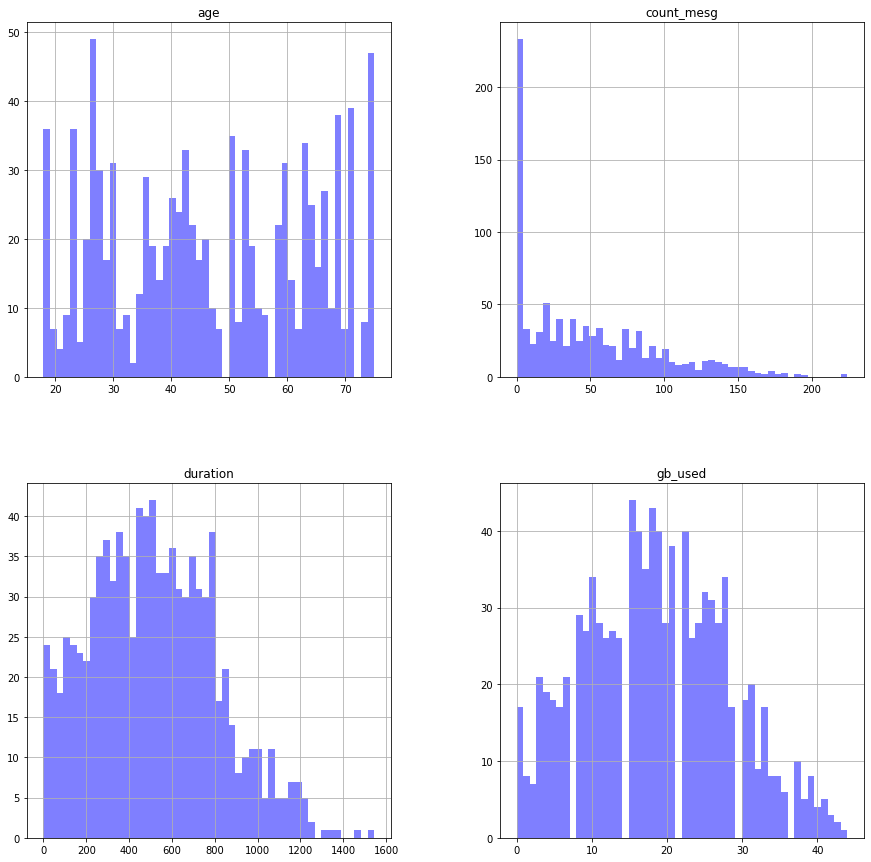

In [69]:
df_ultra[['duration','count_mesg','gb_used','age']].hist(color='blue', alpha=0.5, bins=50, figsize = (15,15))

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2e56b5860>,
      dtype=object)

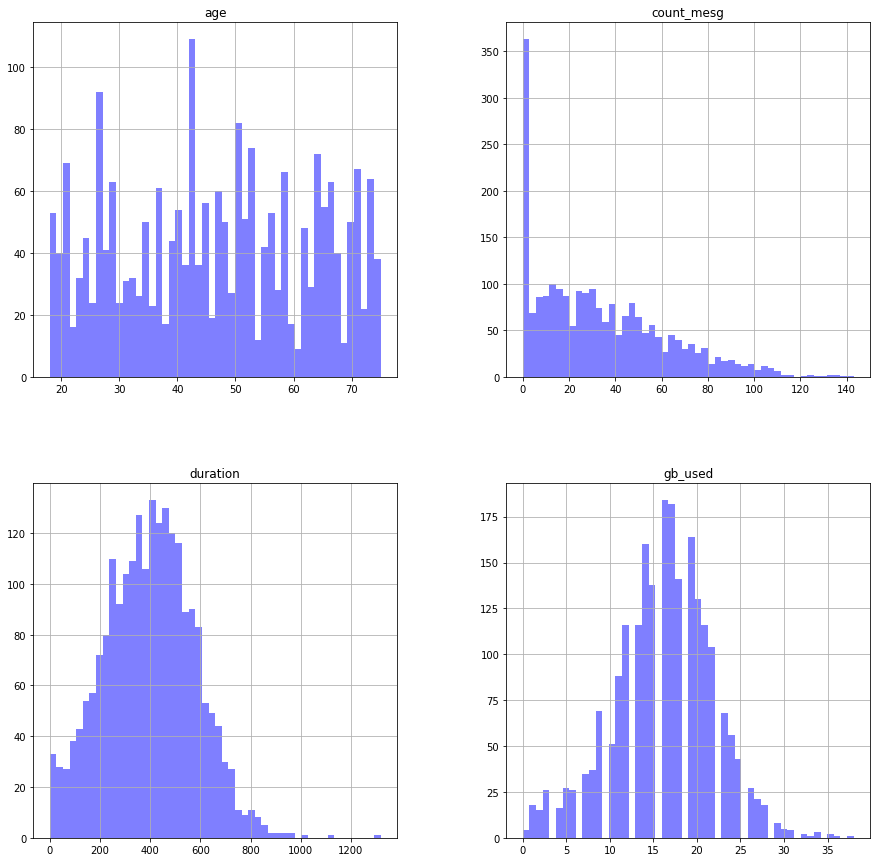

In [70]:
df_smart[['duration','count_mesg','gb_used','age']].hist(color='blue', alpha=0.5, bins=50, figsize = (15,15));

## Нормальное распределение

Исходя из гистограмм для проверки математического ожидания нормального распределения буду проверять только на данных траффика звонков и "интернет-пакета" для двух выборок разделенных по тарифам.

Для этого напишем функцию которая будет принимать на вход ожидания и возвращать результат проверки.

In [71]:
# математическим ожиданием c стандартным отклонением.
def normal_distr(betweenIn, betweenOut, expect):

    distr = st.norm(betweenIn, betweenOut) 

    result = distr.cdf(expect) # считаем вероятность получить значение x 
    return result

In [72]:
# какова вероятность попасть между значениями
def varible_between(deviation1, deviation2, betweenIn, betweenOut):

    distr = st.norm(deviation1, deviation2) 

    x1 = betweenIn
    x2 = betweenOut

    result = distr.cdf(x2) - distr.cdf(x1)
    return result

count    953.000000
mean      18.535152
std        9.525456
min        0.000000
25%       11.000000
50%       18.000000
75%       25.000000
max       44.000000
Name: gb_used, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2e56caa90>]],
      dtype=object)

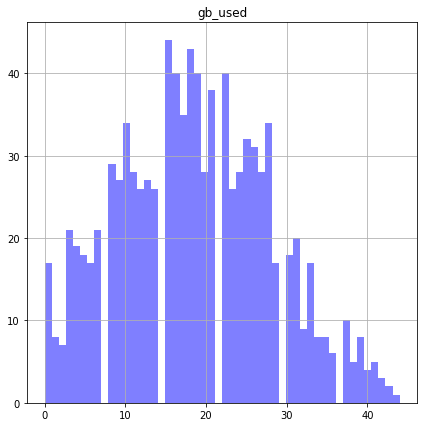

In [73]:
# для тарифа "ultra" посмотрим распределения
print(df_ultra['gb_used'].describe())
df_ultra[['gb_used']].hist(color='blue', alpha=0.5, bins=50, figsize = (7,7))

In [74]:
# Вероятность стандартного распределения 
result = normal_distr(18, 9, 18)
print('Вероятность стандартного распределения для тарифа ultra по данным интернет траффика составляет: ',result)

Вероятность стандартного распределения для тарифа ultra по данным интернет траффика составляет:  0.5


count     953.000000
mean      514.803778
std       291.297922
min         0.000000
25%       289.000000
50%       496.000000
75%       715.000000
max      1545.000000
Name: duration, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2e52cd588>]],
      dtype=object)

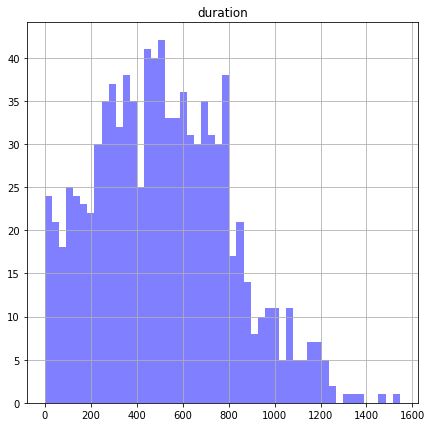

In [75]:
# для тарифа "ultra" посмотрим распределения
print(df_ultra['duration'].describe())
df_ultra[['duration']].hist(color='blue', alpha=0.5, bins=50, figsize = (7,7))

In [76]:
# Вероятность стандартного распределения 
result = normal_distr(500, 150, 400)
print('Вероятность стандартного распределения для тарифа ultra по данным "минуты разговора" составляет: ',result)

Вероятность стандартного распределения для тарифа ultra по данным "минуты разговора" составляет:  0.2524925375469229


count    2223.00000
mean       16.17274
std         5.71604
min         0.00000
25%        13.00000
50%        16.00000
75%        20.00000
max        38.00000
Name: gb_used, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2e5102c88>]],
      dtype=object)

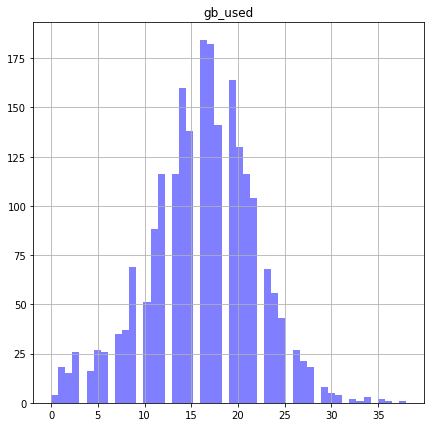

In [77]:
# для тарифа "smart" посмотрим распределения
print(df_smart['gb_used'].describe())
df_smart[['gb_used']].hist(color='blue', alpha=0.5, bins=50, figsize = (7,7))

In [78]:
# Вероятность стандартного распределения 
result = normal_distr(16, 5, 15)
print('Вероятность стандартного распределения для тарифа smart по данным "интерент-траффика" составляет: ',result)

Вероятность стандартного распределения для тарифа smart по данным "интерент-траффика" составляет:  0.42074029056089696


count    2223.000000
mean      397.034638
std       179.655865
min         0.000000
25%       266.000000
50%       401.000000
75%       520.000000
max      1318.000000
Name: duration, dtype: float64


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2e50b9630>]],
      dtype=object)

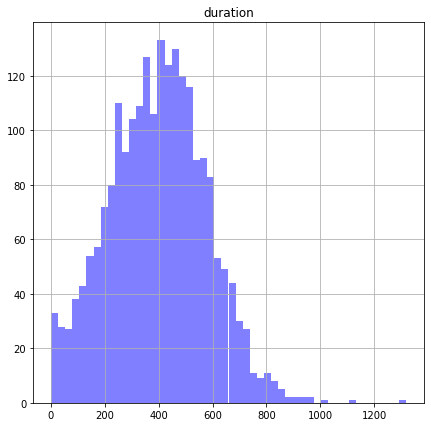

In [79]:
# для тарифа "smart" посмотрим распределения
print(df_smart['duration'].describe())
df_smart[['duration']].hist(color='blue', alpha=0.5, bins=50, figsize = (7,7))

In [80]:
# Вероятность стандартного распределения 
result = normal_distr(550, 120, 380)
print('Вероятность стандартного распределения для тарифа smart по данным "минуты разговора" составляет: ',result)

Вероятность стандартного распределения для тарифа smart по данным "минуты разговора" составляет:  0.43381616738909634


# Проверка гипотез

Есть два вопроса на которые нам предстоит ответить:
    * средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
    * средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;
    
Здесь мы будем применять методы сравнения двух генеральных совокупностей. Зависимых парных я пока не могу придумать какой то правильный вопрос. 

А, что касается проверки средних то тут все понятно и для реализации напишим функцию в котороую надо будет отдавать два столбика датафрейма для проверики их среднего сопоставления. Перед этим придется их сгрупировать по пользователю.




Для уровня значимости, я буду опираться только на построенные граффики и чутье) если мне будет нравится нормальное распределение отрисованное на граффике то я бы установил ее в нормальных общепринятых пределах т.е. -.05 если график будет напоминать нормальное распределение только в пике тогда я сокращу от .01 до .03 (Если я правильно понял тему)

In [81]:
# Преобразование колонки в массив значений
def prepare_array(column_dt):
    
    array_return = []
    
    for i in column_dt:
        array_return.append(i)

    return array_return   

# проверка гипотезы о равенстве средней для двух генеральных совокупностей
def diff_mean_other_group(column_dt1, column_dt2, alpha):

    array_1 = prepare_array(column_dt1)
    array_2 = prepare_array(column_dt2)

    alpha_set = alpha   # критический уровень статистической значимости
                        # если p-value окажется меньше него - отвергнем гипотезу

    results = st.ttest_ind(
        array_1, 
        array_2)

    print('p-значение:', results.pvalue)

    if (results.pvalue < alpha_set):
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

### Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различаются ?

In [82]:
df_user_pay = df.groupby(['user_id', 'tariff', 'city'])
df_user_pay = df_user_pay.agg(sum).reset_index()
df_user_pay.index.names = ['id']

<font color='green'>группируем датасет в для каждогопользователя в разрезе тарифа и города(он нам потом тоже понадобится) </font>

In [83]:
df_ultra_pay = df_user_pay.query('tariff == "ultra"')
df_smart_pay = df_user_pay.query('tariff == "smart"')

<font color='green'>Делим массив на два тарифа</font>

In [84]:
print('Количество пользователей тарифа "ultra" :', len(df_ultra_pay))
print('Количество пользователей тарифа "smart" :', len(df_smart_pay))

Количество пользователей тарифа "ultra" : 149
Количество пользователей тарифа "smart" : 351


<font color='green'>Сравниваем количество строк в массиве так как для чистоты эксперимента нам надо два равных по количеству строк массива.</font>

In [85]:
#  сравним по максимуму
df_smart_pay_pr = df_smart_pay.head(len(df_ultra_pay))
len(df_smart_pay_pr)

149

<font color='green'>приравниваем два массива к наименьшему</font>

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2e4f35390>]],
      dtype=object)

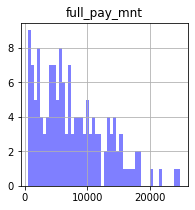

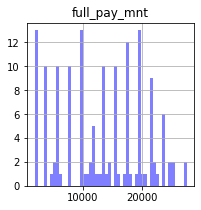

In [86]:
df_smart_pay_pr[['full_pay_mnt']].hist(color='blue', alpha=0.5, bins=50, figsize = (3,3))
df_ultra_pay[['full_pay_mnt']].hist(color='blue', alpha=0.5, bins=50, figsize = (3,3))

<font color='green'>Этими графиками я хочу посмотреть какой же уровень статистической значимости мне стоит выбрать?? и судя по тому как они выглядят, тут конечно и десятки будет мало, но возьму по стандарту .05 (не хуже не лучне не будет)</font>

In [87]:
ultra_pay = df_ultra_pay['full_pay_mnt']
smart_pay = df_smart_pay_pr['full_pay_mnt']

alpha = .05

diff_mean_other_group(ultra_pay,smart_pay,alpha)

p-значение: 2.0911624113223706e-12
Отвергаем нулевую гипотезу


<font color='green'>То чего и стоило ожидать. Мы с увереностью можем сказать, что средняя этих двух категорий очень чильно различается, даже не смотря на переплату перерасхода трафика в тарифе smart</font>

### Альтернативная гипотеза

Сформмирую одну альтернативную гипотезу. Мы узнали, что у людей из тарифа смарт всегда есть перерасхрод и они переплачивают за дополнительные услуги особенно это касается интернета так вот мы постораемся узнать на сколько выгодно людям из тарифа  смарт платить стоитмость тарифа ультра

<font color='green'> тут мне хочется проверить на сколько часто люди из все совокупности тарифа smart перелачивали сверх своего тарифа в 550 руб. я ставлю низкую планку в переплту в 50 рублей. и ожидаю увидеть число 600 руб в месяц (тариф + переплата).</font>

##### нуливая гипотеза: Люди с тарифом smart всегда переплачивают

In [88]:
array_pat_smart = []
    
for i in df_smart['full_pay_mnt']:
    array_pat_smart.append(i)

interested_value = 600

alpha = .05 # критический уровень статистической значимости

results = st.ttest_1samp(
    array_pat_smart, 
    interested_value)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.9274808166624657e-247
Отвергаем нулевую гипотезу


<font color='green'>Так как мы видим, что число не входит в нулевой порог мы с увереностью можем сказать, что люди в большей своей части не переплачивают сверх тарифа</font>

### Cредняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

In [89]:
# Для дальнейшего анализа разделим массив данных на два тарифа
df_moscow = df_user_pay.query('city == "Москва"')
df_nonMoscow = df_user_pay.query('city != "Москва"')

In [90]:
# так как нам надо сравнивать одинаковое количество в массиве посмотрим сколько получилось данных
print('Для Москвы количество пользователей состовляет: ', len(df_moscow))
print('Для остальных регионов количество пользователей состовляет: ', len(df_nonMoscow))

Для Москвы количество пользователей состовляет:  99
Для остальных регионов количество пользователей состовляет:  401


In [91]:
#  сравним по максимуму
df_nonMoscow_pr = df_nonMoscow.head(len(df_moscow))
len(df_nonMoscow_pr)

99

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fd2e4dbd6d8>]],
      dtype=object)

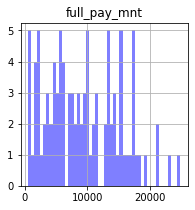

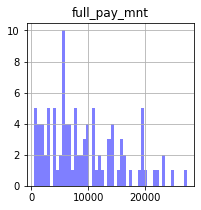

In [92]:
df_nonMoscow_pr[['full_pay_mnt']].hist(color='blue', alpha=0.5, bins=50, figsize = (3,3))
df_moscow[['full_pay_mnt']].hist(color='blue', alpha=0.5, bins=50, figsize = (3,3))

In [93]:
ultra_pay = df_moscow['full_pay_mnt']
smart_pay = df_nonMoscow_pr['full_pay_mnt']

alpha = .05

diff_mean_other_group(ultra_pay,smart_pay,alpha)

p-значение: 0.8816339944850318
Не получилось отвергнуть нулевую гипотезу


<font color='green'>Здесь мы так же используем выборку по двум генеральным совокупностям. Отвечаем на вопрос отличается средняя для стоимость оплаты в месяц для проживающих в Москве и других городах и тут мы можем констатировать, что среденяя оплата тарифа примерно одинаковы.</font>

# Общий вывод

С смаого начала помимо заданых вопросов заданием мне было интересно смотреть на эти данные моим житейским взглядом, стоит ли переплачивать за тариф или нет и что может человека сподвигруть на покупку того или иного тарифа. На второй вопрос мы этим исследованием вряд ли ответим но вот первый становится давольно понятен.
    * _Люди которые платят за тариф ультра чеще всего не приследуют выгоду оптовой покупки трафика в виде мегабайт, минут и смс. Они покупают "гибкость" и "свободу" и готовы за это платить минута стоимости разговора в год у тарифа ультра больше хотя при покупке оптовогво пакета разрезе месяца она стоит меньше._
    * _Тариф смарт преобретают люди бережливые которые его и "выговаривают" иногда переходя за лимит, но никогда не тратят сопостовимые суммы тарифа ультра.
    * Выдвигалось две гипотезы, различается ли средняя выручка для людей из тарифа ультра и тарифа смарт и различатся ли стредняя плата в месяц для людей из Москвы и других регионов. Если первая гипотеза показала, что да действительно средняя выручко для двух этих совокупностей очень сильно отличается то для второй гипотезы разница в средних на общий массив не была критичной и мы можем сказать, что средняя плата в месяц в Москве и регионах похожа.
    * Для альтернативной гипотезы, я задался вопросом переплачивают ли люди из тарифа смарт хотя бы 50 руб в месяц сверх тарифа и она показала, что в основном массиве данных переплата не такое частое явление. 